#**Admission Yield Prediction with Supervised Modeling**

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection & evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Utilities
from sklearn.base import clone
import shap


# **Data Preprocessing**

**Preparing Train and Test Dataset:** Randomizing 20% of the dataset for test set, and 80% of the dataset for train set.

In [3]:
# Load cleaned dataset
df = pd.read_excel('cleaned_IPEDS_data.xlsx')

# Feature selection
X = df.drop(columns=['yield', 'inst_name'])  # Drop target and ID columns
y = df['yield']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical features
categorical_features = ['control', 'locale', 'cluster']
numeric_features = [col for col in X.columns if col not in categorical_features]


# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# **Model Evaluation & Selection Functions**

**Cross Validation**

In [4]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)
feature_names = preprocessor.fit(X_train).get_feature_names_out()


**Evaluating Criteria:** CV R2, Test R2 and Adjusted R2 are used to compare the performances of different models.

In [5]:
# Initiate an array to keep track of results across all models
model_results = []

In [6]:
def evaluate_model(name, pipeline):
    # Cross-validated R² scores
    scores = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=cv)

    # Fit on full training set and predict on test set
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Core performance metrics
    r2 = r2_score(y_test, y_pred)
    train_r2 = pipeline.score(X_train, y_train)
    n = len(y_test)
    p = pipeline.named_steps['preprocessor'].transform(X_test).shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error (caution if y_test has zeros)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        mape = np.nan if np.isinf(mape) or np.isnan(mape) else mape

    # Append metrics to the list
    model_results.append({
        'Model': name,
        'CV R²': scores.mean(),
        'CV Std': scores.std(),
        'Train R²': train_r2,
        'Test R²': r2,
        'Adjusted R²': adj_r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    # Print metrics
    print(f"\n{name}")
    print(f"CV R²:       {scores.mean():.3f}")
    print(f"CV Std:      {scores.std():.3f}")
    print(f"Train R²:    {train_r2:.3f}")
    print(f"Test R²:     {r2:.3f}")
    print(f"Adjusted R²: {adj_r2:.3f}")
    print(f"MSE:         {mse:.3f}")
    print(f"RMSE:        {rmse:.3f}")
    print(f"MAE:         {mae:.3f}")
    if mape is not np.nan:
        print(f"MAPE:        {mape:.2f}%")

    # Optional diagnostic plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} Predictions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pipeline

**Feature Importance:**
permutation_importance from sklearn.inspection is used to compute the feature importance by permuting the values of each feature and measuring the decrease in the model's performance (in this case, R²). The idea is that if a feature is important, permuting its values should significantly reduce the model’s performance.

In [25]:
# Dictionary to store feature importances from each model
perm_importances = {}

In [26]:
def get_permutation_importance(model, name, perm_importances):
    # Transform the test set using the preprocessor
    X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

    # Calculate permutation importance
    perm = permutation_importance(model.named_steps['regressor'], X_test_transformed, y_test, n_repeats=10, random_state=42)

    # Create a DataFrame to store the feature importance
    perm_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm.importances_mean})

    # Store the permutation importances in the dictionary
    perm_importances[name] = perm_df.sort_values(by='Importance', ascending=False).head(10)

    return perm_importances


# **Supervised Modeling**

**1. Linear Regression**


Linear Regression
CV R²:       0.251
CV Std:      0.036
Train R²:    0.297
Test R²:     0.237
Adjusted R²: 0.166
MSE:         0.775
RMSE:        0.880
MAE:         0.645
MAPE:        212.69%


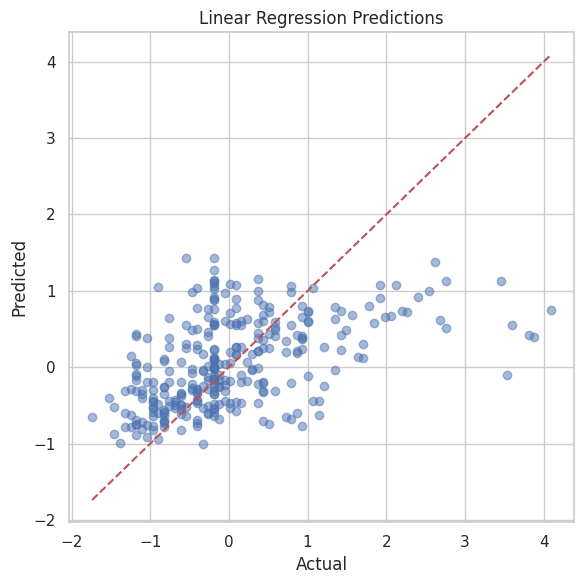

Permutation Importances
                Feature  Importance
25       cat__cluster_3    0.129030
6        num__pct_black    0.103597
3    num__tuitionfee_in    0.095776
23       cat__cluster_1    0.090186
2             num__ugds    0.032978
1   num__admission_rate    0.031922
0          num__sat_avg    0.023797
4   num__tuitionfee_out    0.020935
7     num__pct_hispanic    0.017638
10  cat__control_Public    0.014839


In [29]:
# --- Linear Regression ---
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linear_model = evaluate_model("Linear Regression", linear_pipeline)
coefs = linear_model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(linear_model, "Linear Regression", perm_importances)
print(perm_importances["Linear Regression"])

**2. Lasso Regression**


Lasso Regression
CV R²:       0.253
CV Std:      0.039
Train R²:    0.290
Test R²:     0.243
Adjusted R²: 0.173
MSE:         0.769
RMSE:        0.877
MAE:         0.640
MAPE:        203.86%


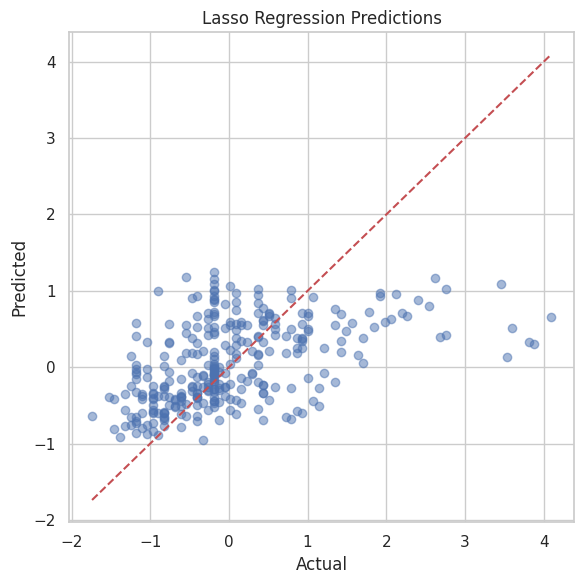

Permutation Importances
                                Feature  Importance
25                       cat__cluster_3    0.149113
6                        num__pct_black    0.090403
23                       cat__cluster_1    0.060844
4                   num__tuitionfee_out    0.053907
1                   num__admission_rate    0.029864
3                    num__tuitionfee_in    0.029825
2                             num__ugds    0.028065
0                          num__sat_avg    0.017655
9   cat__control_Private not-for-profit    0.015261
7                     num__pct_hispanic    0.014806


In [30]:
# --- Lasso Regression ---
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=cv, random_state=42))
])
lasso_model = evaluate_model("Lasso Regression", lasso_pipeline)
lasso_coefs = lasso_model.named_steps['regressor'].coef_
lasso_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(lasso_model, "Lasso Regression", perm_importances)
print(perm_importances["Lasso Regression"])

**3. Ridge Regression**


Ridge Regression
CV R²:       0.255
CV Std:      0.036
Train R²:    0.296
Test R²:     0.241
Adjusted R²: 0.170
MSE:         0.771
RMSE:        0.878
MAE:         0.642
MAPE:        208.54%


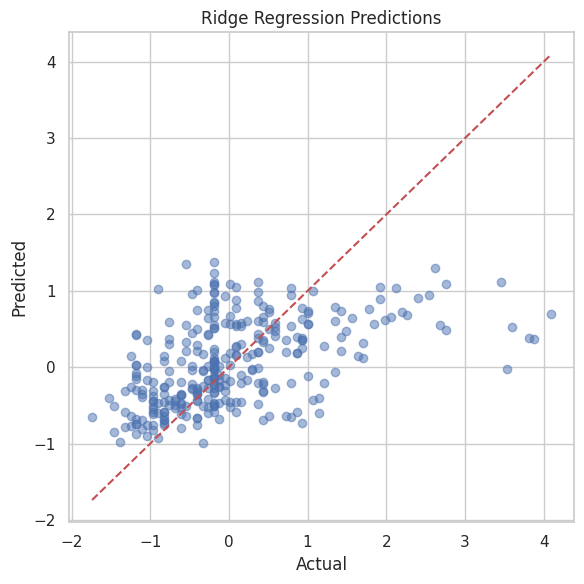

Permutation Importances
                Feature  Importance
25       cat__cluster_3    0.119987
6        num__pct_black    0.092601
23       cat__cluster_1    0.088202
3    num__tuitionfee_in    0.077190
1   num__admission_rate    0.031241
2             num__ugds    0.030583
4   num__tuitionfee_out    0.030103
0          num__sat_avg    0.022217
7     num__pct_hispanic    0.015178
10  cat__control_Public    0.011869


In [31]:
# --- Ridge Regression ---
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(cv=cv))
])
ridge_model = evaluate_model("Ridge Regression", ridge_pipeline)
ridge_coefs = ridge_model.named_steps['regressor'].coef_
ridge_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(ridge_model, "Ridge Regression", perm_importances)
print(perm_importances["Ridge Regression"])

**4. Decision Tree**


Decision Tree
CV R²:       -0.269
CV Std:      0.108
Train R²:    1.000
Test R²:     -0.179
Adjusted R²: -0.289
MSE:         1.197
RMSE:        1.094
MAE:         0.760
MAPE:        326.99%


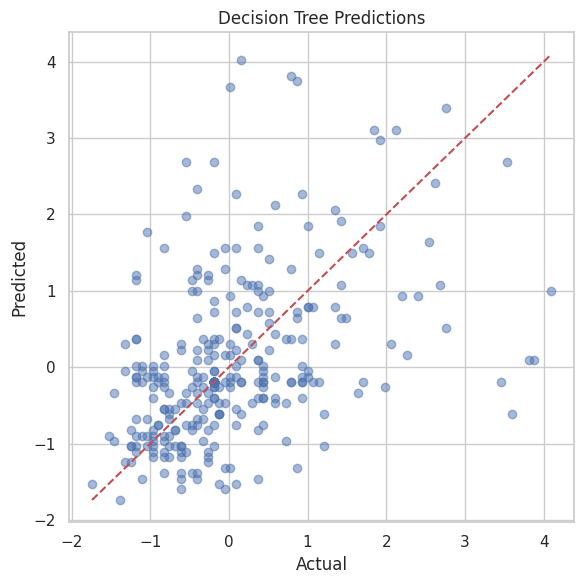

Permutation Importances
                      Feature  Importance
25             cat__cluster_3    1.530983
5              num__pct_white    0.567558
1         num__admission_rate    0.334863
2                   num__ugds    0.266844
3          num__tuitionfee_in    0.256145
4         num__tuitionfee_out    0.181047
8              num__pct_asian    0.106262
0                num__sat_avg    0.078848
7           num__pct_hispanic    0.022706
17  cat__locale_Suburb: Large    0.014463


In [32]:
# --- Decision Tree with GridSearchCV ---
dt_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)),
    'regressor__min_samples_split': list(range(2, 11, 1))
}
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_model = evaluate_model("Decision Tree", dt_pipeline)
dt_importances = dt_model.named_steps['regressor'].feature_importances_
dt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt_importances})
print("Permutation Importances")
perm_importances = get_permutation_importance(dt_model, "Decision Tree", perm_importances)
print(perm_importances["Decision Tree"])

**5. Random Forest**


Random Forest
CV R²:       0.392
CV Std:      0.061
Train R²:    0.919
Test R²:     0.430
Adjusted R²: 0.378
MSE:         0.578
RMSE:        0.761
MAE:         0.533
MAPE:        175.81%


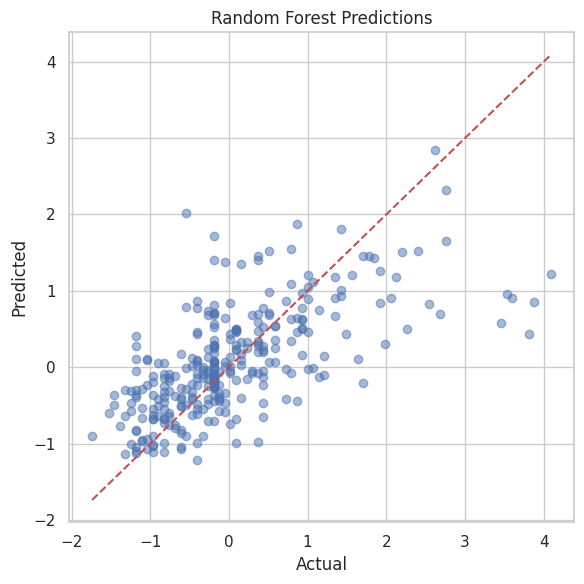

Permutation Importances
                Feature  Importance
25       cat__cluster_3    0.662845
1   num__admission_rate    0.230813
5        num__pct_white    0.205221
3    num__tuitionfee_in    0.089990
2             num__ugds    0.061278
0          num__sat_avg    0.044356
4   num__tuitionfee_out    0.025253
7     num__pct_hispanic    0.016820
6        num__pct_black    0.008254
8        num__pct_asian    0.006471


In [33]:
# --- Random Forest with GridSearchCV ---
rf_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)) + [None],
    'regressor__min_samples_split': list(range(2, 11, 1))
}
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_model = evaluate_model("Random Forest", rf_pipeline)
rf_importances = rf_model.named_steps['regressor'].feature_importances_
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
print("Permutation Importances")
perm_importances = get_permutation_importance(rf_model, "Random Forest", perm_importances)
print(perm_importances["Random Forest"])

**6. XGBoost**


XGBoost
CV R²:       0.339
CV Std:      0.057
Train R²:    0.995
Test R²:     0.347
Adjusted R²: 0.286
MSE:         0.663
RMSE:        0.814
MAE:         0.578
MAPE:        230.46%


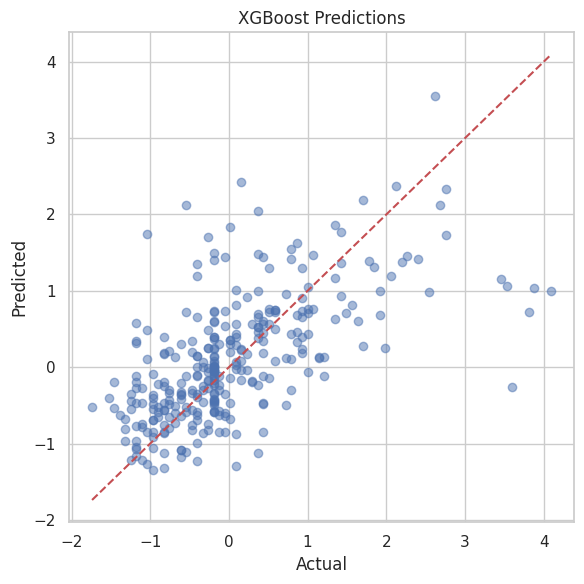

Permutation Importances
                                Feature  Importance
25                       cat__cluster_3    0.634855
1                   num__admission_rate    0.254343
3                    num__tuitionfee_in    0.211381
5                        num__pct_white    0.195115
4                   num__tuitionfee_out    0.099524
0                          num__sat_avg    0.070574
2                             num__ugds    0.062315
9   cat__control_Private not-for-profit    0.037870
8                        num__pct_asian    0.026489
7                     num__pct_hispanic    0.012913


In [34]:
# --- XGBoost with GridSearchCV ---
xgb_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2]
}
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])
xgb_model = evaluate_model("XGBoost", xgb_pipeline)
print("Permutation Importances")
perm_importances = get_permutation_importance(xgb_model, "XGBoost", perm_importances)
print(perm_importances["XGBoost"])


**7. Ensemble Model: Voting Regressor**


Voting Regressor
CV R²:       0.392
CV Std:      0.049
Train R²:    0.858
Test R²:     0.414
Adjusted R²: 0.360
MSE:         0.595
RMSE:        0.771
MAE:         0.551
MAPE:        183.66%


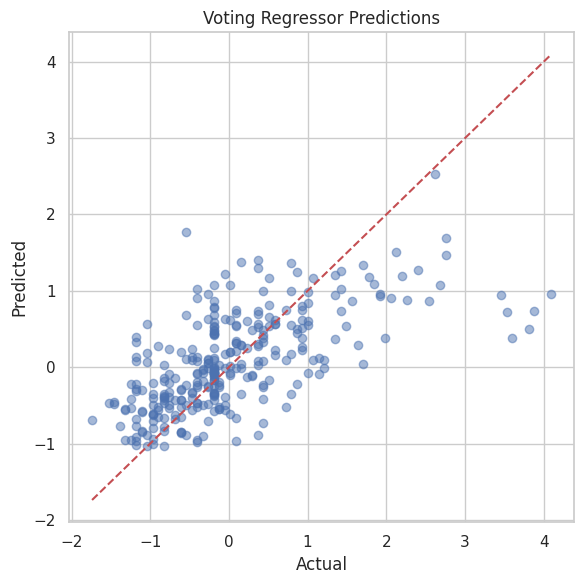

Permutation Importances
                                Feature  Importance
25                       cat__cluster_3    0.441248
1                   num__admission_rate    0.174488
5                        num__pct_white    0.103095
3                    num__tuitionfee_in    0.092811
4                   num__tuitionfee_out    0.057238
2                             num__ugds    0.049395
0                          num__sat_avg    0.036417
9   cat__control_Private not-for-profit    0.018799
6                        num__pct_black    0.017079
7                     num__pct_hispanic    0.014770


In [35]:
# --- Voting Regressor ---

estimators = [
    ('lasso', clone(lasso_model.named_steps['regressor'])),
    ('rf', clone(rf_model.named_steps['regressor'])),
    ('xgb', clone(xgb_model.named_steps['regressor']))
]

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor(estimators=estimators, n_jobs=-1))
])

voting_model = evaluate_model("Voting Regressor", voting_pipeline)

print("Permutation Importances")
perm_importances = get_permutation_importance(voting_model, "Voting Regressor", perm_importances)
print(perm_importances["Voting Regressor"])


**8. Ensemble Model: Stacking Regressor**


Stacking Regressor
CV R²:       0.400
CV Std:      0.054
Train R²:    0.923
Test R²:     0.433
Adjusted R²: 0.380
MSE:         0.576
RMSE:        0.759
MAE:         0.536
MAPE:        178.22%


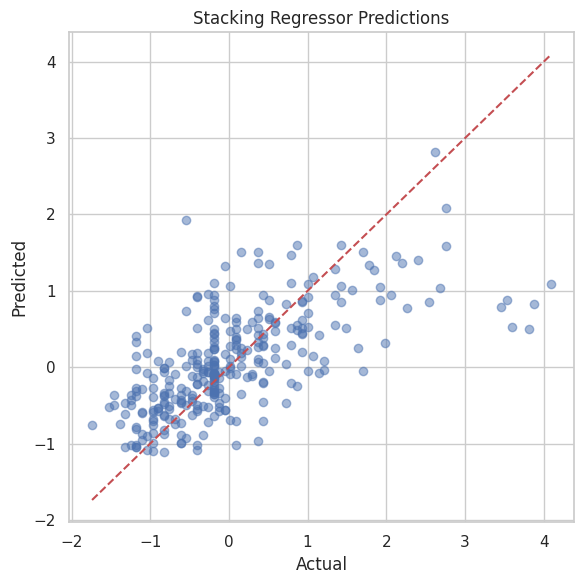

Permutation Importances
                                Feature  Importance
25                       cat__cluster_3    0.571331
1                   num__admission_rate    0.213446
5                        num__pct_white    0.161838
3                    num__tuitionfee_in    0.100569
2                             num__ugds    0.055290
4                   num__tuitionfee_out    0.047309
0                          num__sat_avg    0.041379
7                     num__pct_hispanic    0.015075
9   cat__control_Private not-for-profit    0.013037
8                        num__pct_asian    0.009230


In [36]:
# --- Stacking Regressor ---
estimators = [
    ('lasso', clone(lasso_model.named_steps['regressor'])),
    ('rf', clone(rf_model.named_steps['regressor'])),
    ('xgb', clone(xgb_model.named_steps['regressor']))
]
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), cv=cv, n_jobs=-1))
])
stacking_model = evaluate_model("Stacking Regressor", stacking_pipeline)
print("Permutation Importances")
perm_importances = get_permutation_importance(stacking_model, "Stacking Regression", perm_importances)
print(perm_importances["Stacking Regression"])

# **Performance Summary**

<ipython-input-18-4795dad1450a>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="Score", hue="Metric", data=results_long, ci=None)


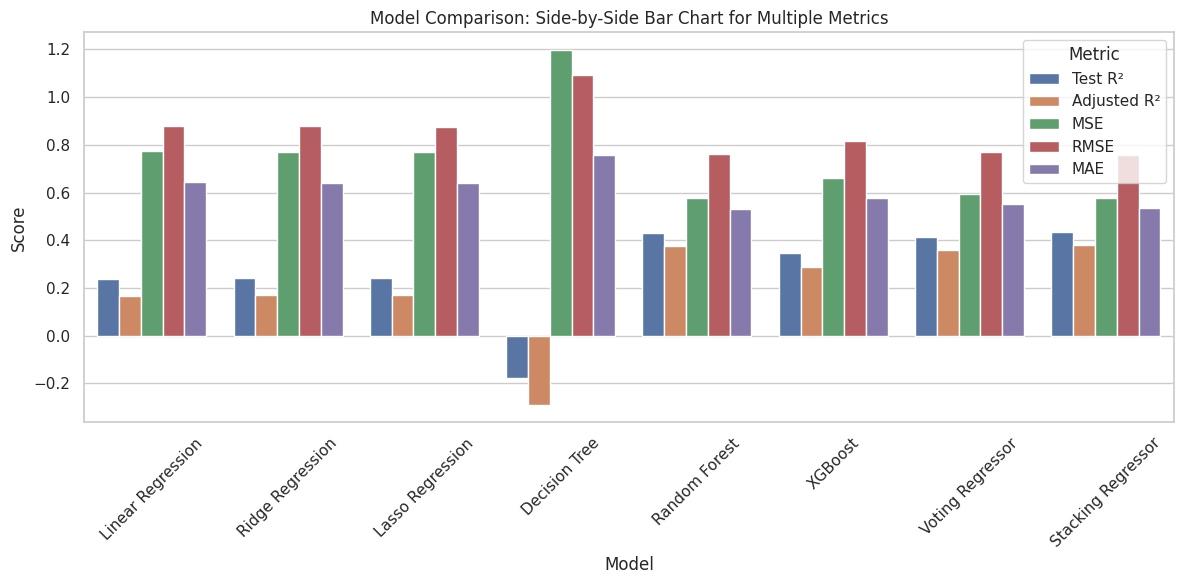

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model_results' is already populated with all the evaluation metrics

# Convert the model results to a DataFrame
results_df = pd.DataFrame(model_results)

# Reshape the DataFrame for side-by-side comparison
metrics_to_plot = ['Test R²', 'Adjusted R²', 'MSE', 'RMSE', 'MAE']  # You can choose which metrics you want to plot
results_long = pd.melt(results_df, id_vars=['Model'], value_vars=metrics_to_plot,
                       var_name='Metric', value_name='Score')

# Set the figure size and plotting style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the side-by-side bar plot
sns.barplot(x="Model", y="Score", hue="Metric", data=results_long, ci=None)

# Add labels and title
plt.title("Model Comparison: Side-by-Side Bar Chart for Multiple Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.tight_layout()

# Show the plot
plt.show()


In [41]:
def plot_permutation_importances(perm_importances):
    # Set the number of models
    n_models = len(perm_importances)

    # Get the feature names and the maximum importance value for scaling
    feature_names = perm_importances[list(perm_importances.keys())[0]]['Feature']
    max_importance = max([df['Importance'].max() for df in perm_importances.values()])

    # Set up the figure and axes for side-by-side plots
    fig, ax = plt.subplots(figsize=(12, 8))

    # Number of bars per model
    width = 0.8 / n_models
    index = np.arange(len(feature_names))

    # Plot each model's permutation importance side by side
    for i, (model_name, importance_df) in enumerate(perm_importances.items()):
        # Shift the bars by width for each model
        ax.barh(index + i * width, importance_df['Importance'], height=width, label=model_name)

    # Labeling the axes and title
    ax.set_yticks(index + width * (n_models - 1) / 2)
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Permutation Importance')
    ax.set_title('Permutation Importance for Different Models')

    # Show legend and tight layout for better fitting
    ax.legend(loc='upper right')
    plt.tight_layout()

    # Display the plot
    plt.show()


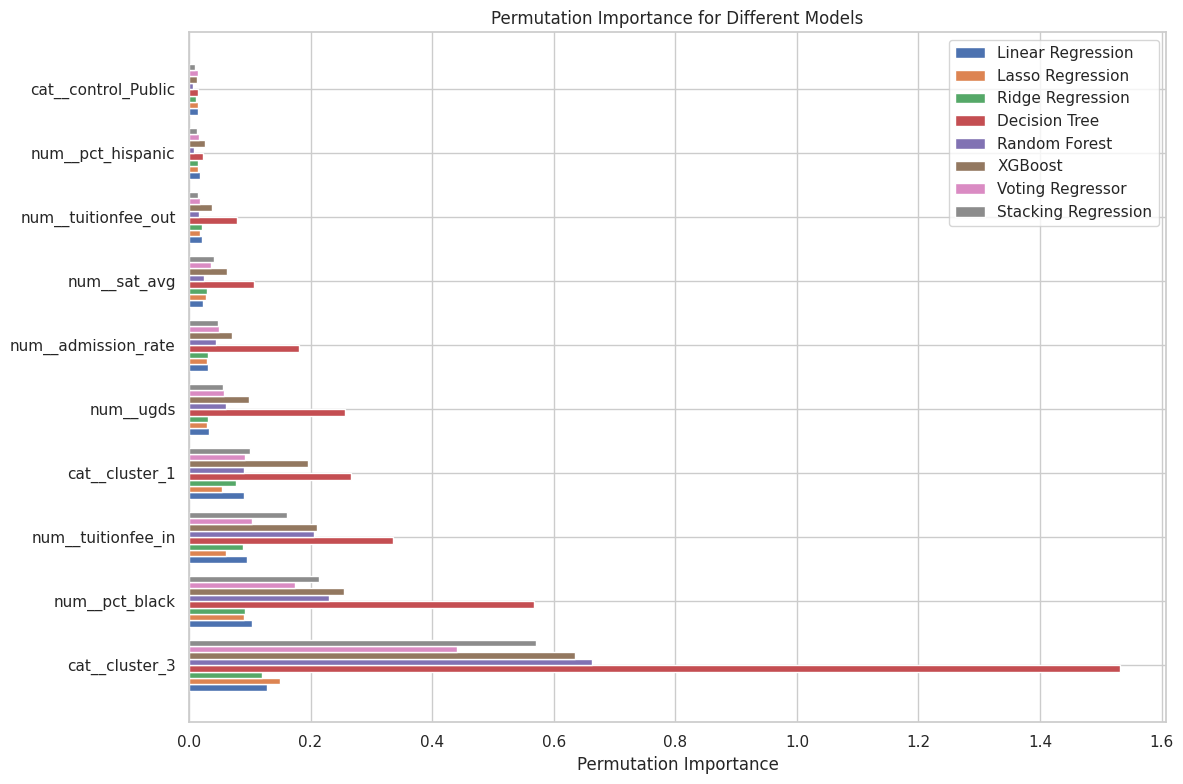

In [42]:
plot_permutation_importances(perm_importances)